In [37]:
import sys
sys.path.append('/SEE-MTDA/see')
from sc.mesher.mesher import Mesher
import numpy as np
import os
import glob
import pickle
from pathlib import Path
from sc.datasets.shared_utils import *
import open3d as o3d
from easydict import EasyDict
import yaml
from PIL import Image
from tqdm import tqdm

def cfg_from_yaml_file(cfg_file):
    cfg = EasyDict()
    print("\n----- Cfgs -----")
    with open(cfg_file, 'r') as f:
        yaml_config = yaml.safe_load(f)
        print(yaml.dump(yaml_config))

    cfg.update(EasyDict(yaml_config))

    return cfg

cfg_file = '/SEE-MTDA/see/sc/cfgs/NUS-GM-EXT-PCN-NORMSCALE-COARSE.yaml'
cfg = cfg_from_yaml_file(cfg_file)
mesher = Mesher(cfg=cfg, cfg_path=cfg_file)


----- Cfgs -----
DATASET:
  CLASSES:
  - car
  CUSTOM: true
  DET2D_MASK: false
  LIDAR_NSWEEPS: 2
  NAME: nuscenes
DATA_PATH: /SEE-MTDA/data/nuscenes/custom_t4025-v3980
MESHER:
  EXPORT_NAME: PCN-normscale-coarse
  IOU_THRESH: 0.6
  MIN_LIDAR_PTS_TO_MESH: 5
  NAME: ext_mesh
  REPLACE_OBJECT_WITH_MESH:
    POINT_DISTANCE_THRESH: 0.1

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 27.696 seconds.
Reverse indexing ...
Done reverse indexing in 6.8 seconds.
Loading sample records...
NuScenesObjects initialised!

Mesher Initialised!


In [44]:
sample_idx = 0
sample_token = mesher.data_obj.get_sample_token_from_idx(sample_idx)
save_fname = str(mesher.save_dir / f'{sample_token}#{sample_idx:06}')
save_fname = save_fname + '.pcd'
os.makedirs(os.path.dirname(save_fname), exist_ok=True)

In [2]:
mesher.min_lidar_pts_to_mesh = 50

In [13]:
mesher.mesher_cfg.CLUSTERING.EPS_SCALING = 4
mesher.mesher_cfg.VRES = 0.8
mesher.mesher_cfg

{'NAME': 'det_mesh',
 'MIN_LIDAR_PTS_TO_MESH': 50,
 'VRES': 0.8,
 'CLUSTERING': {'NAME': 'db_scan', 'EPS_SCALING': 4},
 'MESH_ALGORITHM': {'NAME': 'ball_pivoting',
  'UPPER_RADIUS': 1.155,
  'LOWER_RADIUS': 0.01},
 'SAMPLING': {'NAME': 'vres_ring_based_sampling',
  'TYPE': 'poisson',
  'OPTIMAL_RING_HEIGHT': 0.05},
 'REPLACE_OBJECT_WITH_MESH': {'POINT_DISTANCE_THRESH': 0.1}}

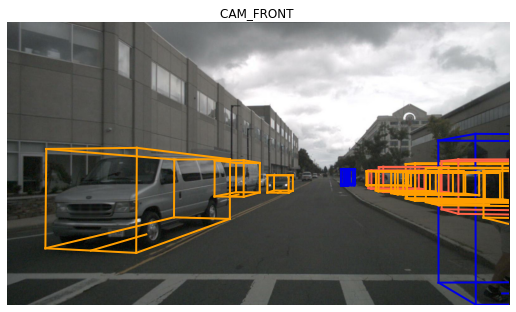

In [71]:
sample = mesher.data_obj.nusc.get('sample', '66ef24c58f8649f185eb9ddc0a2e7f0b')
sensor = 'CAM_FRONT'
cam_front_data = mesher.data_obj.nusc.get('sample_data', sample['data'][sensor])
mesher.data_obj.nusc.render_sample_data(cam_front_data['token'])

In [162]:
idx = 44
mesher.data_obj.nusc.get('sample_annotation', sample['anns'][idx])

{'token': 'd9006f68a040405eb3b9736d2df0a3df',
 'sample_token': '66ef24c58f8649f185eb9ddc0a2e7f0b',
 'instance_token': '2706cc4eb61844a1a5c7a5cb766ffc2e',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [1744.95, 868.984, 0.992],
 'size': [2.006, 5.785, 1.988],
 'rotation': [0.0200175897113291, 0.0, 0.0, 0.9997996279766006],
 'prev': '89d94a68474d44c1afb2557557f322eb',
 'next': '220d1e278156420bb48a65e89eec6ff4',
 'num_lidar_pts': 339,
 'num_radar_pts': 4,
 'category_name': 'vehicle.car'}

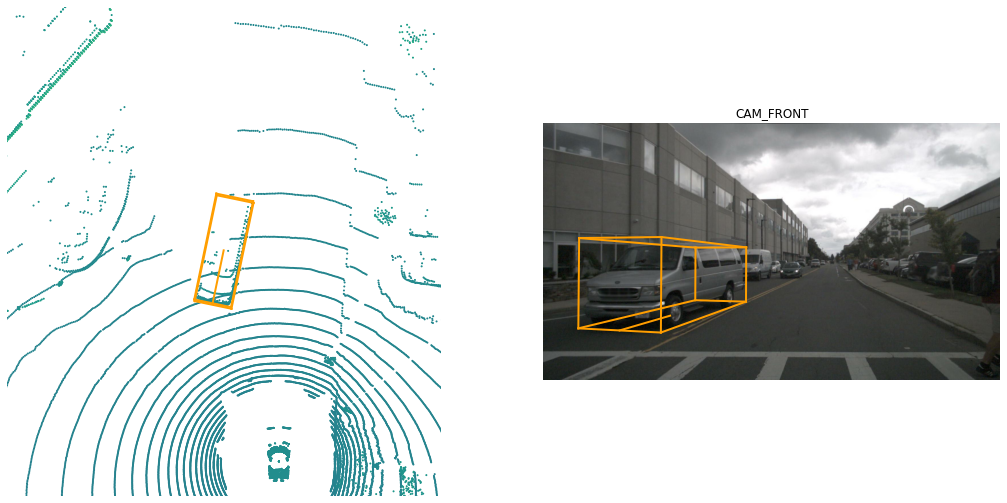

In [163]:
mesher.data_obj.nusc.render_annotation(sample['anns'][idx])

In [68]:
mesher.data_obj.nusc.list_categories()

Category stats for split v1.0-trainval:
animal                      n=  787, width= 0.37±0.13, len= 0.86±0.36, height= 0.60±0.20, lw_aspect= 2.35±0.69
human.pedestrian.adult      n=208240, width= 0.67±0.13, len= 0.73±0.19, height= 1.77±0.18, lw_aspect= 1.11±0.26
human.pedestrian.child      n= 2066, width= 0.51±0.14, len= 0.53±0.15, height= 1.38±0.25, lw_aspect= 1.05±0.23
human.pedestrian.constructi n= 9161, width= 0.72±0.20, len= 0.71±0.20, height= 1.74±0.30, lw_aspect= 1.02±0.29
human.pedestrian.personal_m n=  395, width= 0.62±0.12, len= 1.18±0.31, height= 1.71±0.27, lw_aspect= 1.98±0.64
human.pedestrian.police_off n=  727, width= 0.73±0.14, len= 0.69±0.13, height= 1.83±0.14, lw_aspect= 0.97±0.18
human.pedestrian.stroller   n= 1072, width= 0.63±0.13, len= 0.95±0.27, height= 1.17±0.15, lw_aspect= 1.58±0.68
human.pedestrian.wheelchair n=  503, width= 0.77±0.10, len= 1.09±0.23, height= 1.37±0.09, lw_aspect= 1.42±0.23
movable_object.barrier      n=152087, width= 2.53±0.64, len= 0.50±0.17,

In [164]:
sample_idx = 457
pcd_gtboxes = mesher.get_pcd_gtboxes(sample_idx)
i_cloud = mesher.data_obj.get_mask_instance_clouds(sample_idx)
print(f'{len(i_cloud)} detected')
print([len(cloud) for cloud in i_cloud])
list_mesh_instances = mesher.mesh_det_pts(i_cloud, sample_idx)
print(f'{len(list_mesh_instances)} meshed')

Cameras not specified. Using self.camera_channels = ['CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT']
Returning instances for all 6 cameras
33 detected
[46, 1110, 12, 31, 16, 4, 2, 4, 17, 10, 12, 20, 12, 11, 1, 15, 23, 16, 2, 3, 2, 46, 25, 5, 11, 2, 301, 223, 176, 44, 57, 25, 6]
4 meshed


In [165]:
opcd = pcd_gtboxes['pcd']
opcd.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([opcd] + list_mesh_instances)

In [166]:
opcd = pcd_gtboxes['pcd']
opcd.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([opcd] + convert_to_o3dpcd(i_cloud))

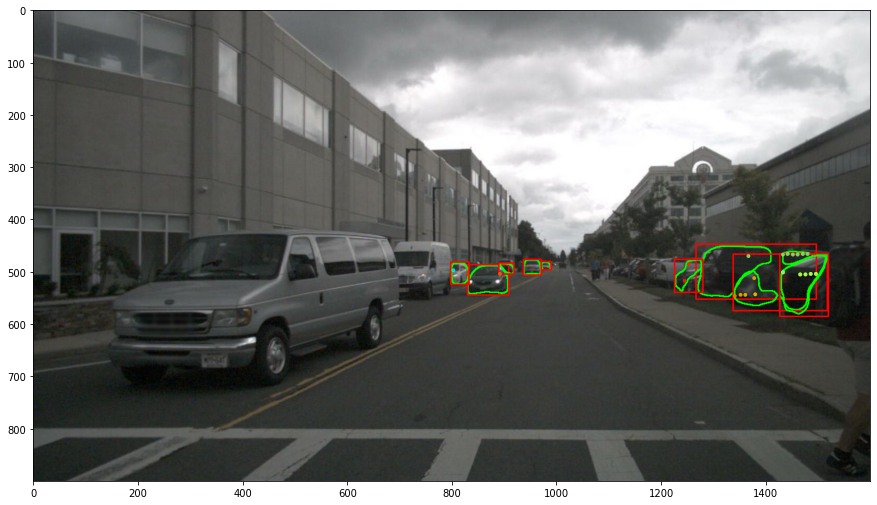

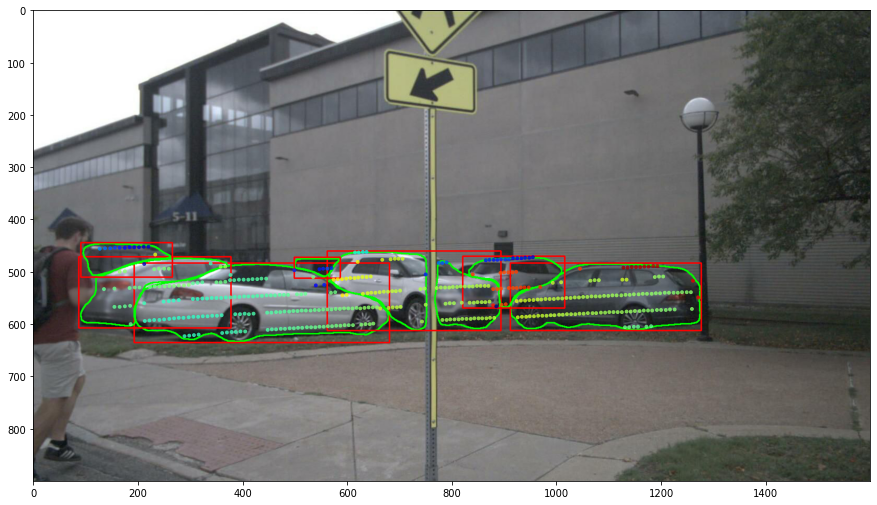

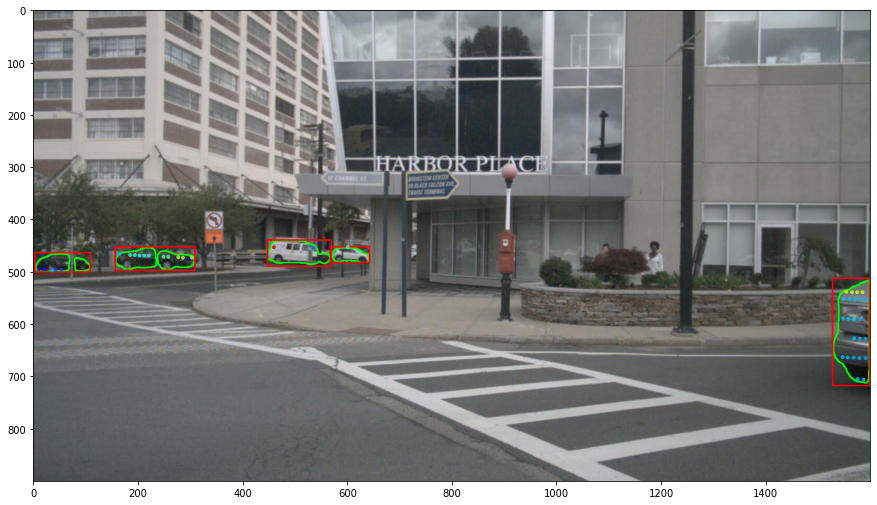

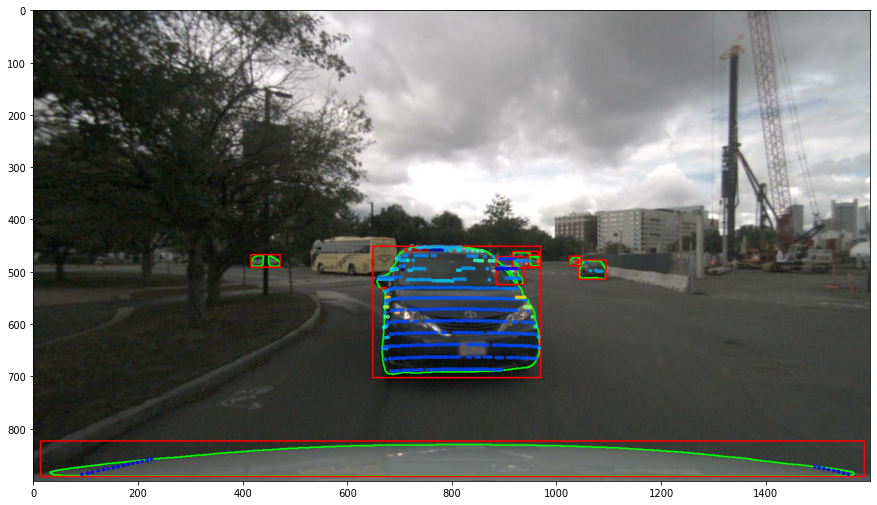

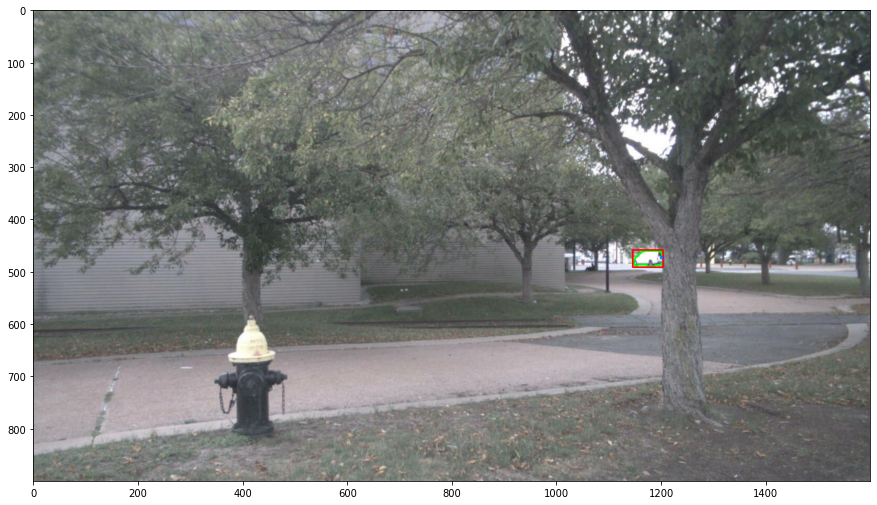

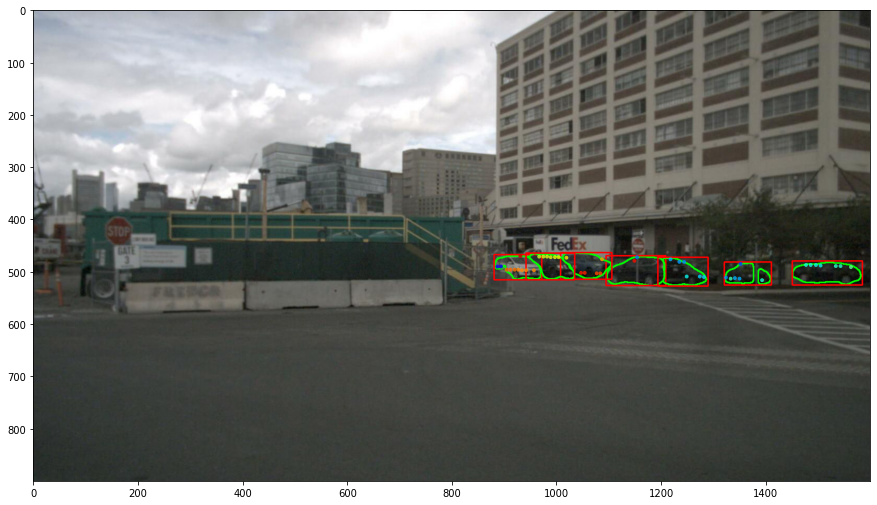

In [167]:
mesher.data_obj.render_pointcloud_in_image(sample_idx, camera_channel='CAM_FRONT', mask=True)
mesher.data_obj.render_pointcloud_in_image(sample_idx, camera_channel='CAM_FRONT_RIGHT', mask=True)
mesher.data_obj.render_pointcloud_in_image(sample_idx, camera_channel='CAM_FRONT_LEFT', mask=True)
mesher.data_obj.render_pointcloud_in_image(sample_idx, camera_channel='CAM_BACK', mask=True)
mesher.data_obj.render_pointcloud_in_image(sample_idx, camera_channel='CAM_BACK_RIGHT', mask=True)
mesher.data_obj.render_pointcloud_in_image(sample_idx, camera_channel='CAM_BACK_LEFT', mask=True)

In [26]:
import open3d as o3d

def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd

def opd_to_boxpts(box):
    """
    Takes an array containing [x,y,z,l,w,h,r], and returns an [8, 3] matrix that 
    represents the [x, y, z] for each 8 corners of the box.
    
    Note: Openpcdet __getitem__ gt_boxes are in the format [x,y,z,l,w,h,r,alpha]
    where alpha is "observation angle of object, ranging [-pi..pi]"
    """
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[0:3]
    l, w, h = box[3], box[4], box[5] # waymo, nusc, kitti is all l,w,h after OpenPCDet processing
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([[l/2, w/2, h/2],
                             [l/2, -w/2, h/2],
                             [-l/2, w/2, h/2],
                             [-l/2, -w/2, h/2],
                             [l/2, w/2, -h/2],
                             [l/2, -w/2, -h/2],
                             [-l/2, w/2, -h/2],
                             [-l/2, -w/2, -h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), np.sin(rotation), 0.0],
        [-np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])
    vcbox = bounding_box @ rotation_matrix
    vcbox += box[:3]
    
    return vcbox

def boxpts_to_o3dbox(box_pts):
    boxpts = o3d.utility.Vector3dVector(box_pts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

    
o3d.visualization.draw_geometries([convert_to_o3dpcd(final_pcd)])

In [46]:
sample_record = mesher.data_obj.sample_records[167]
sample_token = sample_record['token']
tinfos_idx = mesher.data_obj.find_info_idx(mesher.data_obj.infos['train'], sample_token)
vinfos_idx = mesher.data_obj.find_info_idx(mesher.data_obj.infos['val'], sample_token)
tinfos_idx, vinfos_idx

(167, -1)

In [47]:
mesher.data_obj.infos['train'][tinfos_idx]['gt_names']

array(['car', 'car', 'car', 'car', 'car', 'traffic_cone', 'car', 'car',
       'car', 'traffic_cone', 'car', 'ignore', 'car', 'car', 'car',
       'pedestrian', 'car', 'car', 'car', 'car', 'car', 'car', 'barrier',
       'car', 'car', 'car', 'car', 'car', 'car', 'traffic_cone', 'car',
       'traffic_cone', 'car', 'pedestrian', 'traffic_cone', 'car'],
      dtype='<U12')

In [48]:
mesher.data_obj.infos['train'][tinfos_idx]['num_meshed_lidar_pts']

KeyError: 'num_meshed_lidar_pts'

In [42]:
def text_3d(text, pos, direction=None, degree=90.0, density=10, font='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', font_size=16):
    """
    Generate a 3D text point cloud used for visualization.
    :param text: content of the text
    :param pos: 3D xyz position of the text upper left corner
    :param direction: 3D normalized direction of where the text faces
    :param degree: in plane rotation of text
    :param font: Name of the font - change it according to your system
    :param font_size: size of the font
    :return: o3d.geoemtry.PointCloud object
    """
    if direction is None:
        direction = (1., 0., 0.)

    from PIL import Image, ImageFont, ImageDraw
    from pyquaternion import Quaternion

    font_obj = ImageFont.truetype(font, font_size * density)
    font_dim = font_obj.getsize(text)

    img = Image.new('RGB', font_dim, color=(255, 255, 255))
    draw = ImageDraw.Draw(img)
    draw.text((0, 0), text, font=font_obj, fill=(0, 0, 0))
    img = np.asarray(img)
    img_mask = img[:, :, 0] < 128
    indices = np.indices([*img.shape[0:2], 1])[:, img_mask, 0].reshape(3, -1).T

    pcd = o3d.geometry.PointCloud()
    pcd.colors = o3d.utility.Vector3dVector(img[img_mask, :].astype(float) / 255.0)
    pcd.points = o3d.utility.Vector3dVector(indices / 1000 / density)

    raxis = np.cross([0.0, 0.0, 1.0], direction)
    if np.linalg.norm(raxis) < 1e-6:
        raxis = (0.0, 0.0, 1.0)
    trans = (Quaternion(axis=raxis, radians=np.arccos(direction[2])) *
             Quaternion(axis=direction, degrees=degree)).transformation_matrix
    trans[0:3, 3] = np.asarray(pos)
    pcd.transform(trans)
    return pcd

In [44]:
gt_boxes = mesher.data_obj.infos['train'][tinfos_idx]['gt_boxes']
pts = mesher.data_obj.get_pointcloud(tinfos_idx, nsweeps=2)
opcd = convert_to_o3dpcd(pts)

o3dboxes = [boxpts_to_o3dbox(opd_to_boxpts(box)) for box in gt_boxes]
objs = [opcd.crop(o3dbox) for o3dbox in o3dboxes]
text_loc = [o3dbox.center + np.array([0,0,o3dbox.extent[2]]) for o3dbox in o3dboxes]
num_pts = [len(obj.points) for obj in objs]
labels = [text_3d(str(npt), loc, font_size=500, density=1) for npt, loc in zip(num_pts, text_loc)]
print('infos num_pts = ', mesher.data_obj.infos['train'][tinfos_idx]['num_lidar_pts'])
print('num_counted_pts = ', num_pts)

o3d.visualization.draw_geometries([opcd] + o3dboxes + labels)

infos num_pts =  [  2  13   5  12 214  12  25  45   3   2   0   6   1 252   1   6  68   6
  21 846  15  20   5   1  19  14   3   0  15   7  34  51   5  54   2   3]
num_counted_pts =  [2, 23, 10, 24, 432, 24, 47, 94, 4, 3, 0, 11, 2, 492, 2, 11, 128, 10, 41, 1686, 29, 42, 11, 3, 33, 31, 4, 0, 30, 9, 69, 103, 9, 107, 3, 7]
